# Signal Acquisition Planning

This notebook demonstrates the planning of signal capture and spectral analysis parameters. 

The configuration includes:
- Desired Resolution Bandwidth (RBW): 1 kHz
- Sampling Rate (fs): 20 MHz
- Bandwidth: 20 MHz
- Window Type: Hamming
- Overlap: 50%
- K (averaging factor): 1
- Size planning method: next_5smooth

The notebook uses `plan_capture_parameters()` and `plan_welch_parameters()` functions to calculate optimal FFT size and other parameters based on these requirements.


In [1]:
from rfscope.common.utils.fft_capture_planner import plan_capture_parameters, plan_welch_parameters

In [2]:
plan = {
    'rbw_hz': 1e3,
    'fs_hz': 20e6,
    'bw_hz': 20e6,
    'window': 'hamming',
    'overlap': 0.5,
    'K': 10,
    'size_planner': 'next_5smooth'
}

## Plan Capture Parameters

The `plan_capture_parameters()` function calculates optimal signal acquisition parameters based on the desired specifications. It takes the following inputs:

- rbw_hz: Desired Resolution Bandwidth in Hz (target frequency resolution)
- fs_hz: Sampling rate in Hz  
- bw_hz: Bandwidth in Hz
- window: Window function type (e.g. hamming)
- overlap: Overlap ratio between segments (0 to 1)
- K: Averaging factor
- size_planner: Method for determining FFT size (e.g. next_5smooth)

The function determines parameters like:
- Number of samples needed
- Actual achieved RBW
- Total capture time
- Optimal FFT size

This ensures efficient signal capture while meeting the specified frequency resolution requirements.


In [3]:
plan_capture_parameters(**plan)

{'sample_rate': 20000000.0,
 'num_samples': 152064,
 'rbw_eff': 983.7962962962964,
 'total_time_s': 0.0076032}

The acquisition plan parameters show:

- **Sample Rate**: 20 MHz (20,000,000 samples per second)
- **Number of Samples**: 27,648 samples per capture
- **Effective Resolution Bandwidth**: ~984 Hz (actual achieved RBW)
- **Capture Time**: 1.3824 milliseconds (total time to collect samples)

This plan achieves close to the desired 1 kHz RBW target while optimizing the FFT size for computational efficiency.


## Plan Welch Parameters

The `plan_welch_parameters()` function determines the optimal parameters for Welch's method of power spectral density estimation. It takes the same input parameters as `plan_capture_parameters()`:

- rbw_hz: Desired Resolution Bandwidth in Hz
- fs_hz: Sampling rate in Hz
- bw_hz: Bandwidth in Hz  
- window: Window function type
- overlap: Overlap ratio between segments
- K: Averaging factor
- size_planner: FFT size planning method

The function calculates the optimal parameters for spectral analysis including:
- NFFT: FFT size
- Segment size
- Number of segments
- Amount of overlap between segments
- Resulting frequency resolution

This ensures accurate spectral density estimation while meeting the specified resolution requirements.


In [4]:
plan_welch_parameters(**plan)

{'window': 'hamming',
 'nperseg': 27648,
 'noverlap': 13824,
 'nfft': 27648,
 'scaling': 'density',
 'average': 'mean'}

These Welch's method parameters define how the spectral analysis will be performed:

- **window**: Hamming window is used to reduce spectral leakage
- **nperseg**: 27,648 samples per segment - the length of each segment for FFT analysis 
- **noverlap**: 13,824 samples overlap between segments (50% overlap)
- **nfft**: FFT size of 27,648 points for frequency domain transformation
- **scaling**: 'density' returns power spectral density (power per frequency bin)
- **average**: 'mean' specifies arithmetic mean for averaging multiple segments

These parameters achieve:
- Frequency resolution of ~984 Hz
- Good tradeoff between spectral leakage and frequency resolution
- Efficient processing with 50% overlap between segments


## Simulations

In this section, we present simulation results that illustrate how the total acquisition time and data memory requirements vary as a function of both the measurement bandwidth (BW) and the resolution bandwidth (RBW). The simulations use FFT-based capture planning to estimate the number of samples, total recording time, and memory usage for different parameter combinations. The resulting heatmaps provide a visual understanding of how system performance scales with finer resolution or wider bandwidth configurations.

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

# ---------------------------------
# Main configuration and execution
# ---------------------------------
MAX_MEMORY_GB: int = 10
MAX_MEMORY_KIB: float = MAX_MEMORY_GB * 1024**2

plan = {
    "fs_hz": 20e6,
    "window": "hamming",
    "overlap": 0.5,
    "K": 8,
    "size_planner": "next_5smooth",
}

RBW_LIST = [
    1, 3, 10, 30, 100, 300, 1_000, 3_000, 10_000, 30_000, 100_000, 300_000,
    1_000_000, 3_000_000, 5_000_000,
]

BW_LIST = np.linspace(20e6, 6e9, 50)

time_matrix = np.zeros((len(RBW_LIST), len(BW_LIST)))
samples_matrix_kib = np.zeros((len(RBW_LIST), len(BW_LIST)))

for i, rbw in enumerate(RBW_LIST):
    for j, bw in enumerate(BW_LIST):
        plan["rbw_hz"] = rbw
        plan["bw_hz"] = bw
        params = plan_capture_parameters(**plan)
        time_matrix[i, j] = params["total_time_s"]
        samples_matrix_kib[i, j] = (params["num_samples"] * 2) / 2**10  # 2 IQ, 8 bits

In [33]:
def plot_capture_time_matrix(
    time_matrix: np.ndarray,
        *,
    BW: np.ndarray,
    RBW: list[float],
    max_time_s: float = 60.0
) -> None:
    """
    Plot a logarithmic heatmap of capture time vs. bandwidth and resolution bandwidth.

    Parameters
    ----------
    time_matrix : np.ndarray
        Matrix of total capture times in seconds.
    BW : np.ndarray
        Array of measurement bandwidth values (Hz).
    RBW : list of float
        List of resolution bandwidth values (Hz)..
    max_time_s : float, optional
        Maximum allowed acquisition time to display (default is 60 s).

    Returns
    -------
    None
        Displays a matplotlib figure.

    Notes
    -----
    - Points exceeding `max_time_s` are marked with an "×".
    - Entries exceeding `MAX_MEMORY_KIB` are hidden (set to zero).
    - Uses logarithmic color normalization (LogNorm) for better dynamic range.
    """

    # Replace invalid or zero values with minimum positive
    valid_values = time_matrix[np.isfinite(time_matrix) & (time_matrix > 0)]
    vmin = np.nanmin(valid_values) if valid_values.size else 1e-6
    vmax = np.nanmax(valid_values) if valid_values.size else 1.0

    # PSS: Used `matshow` for consistent orientation with RBW rows and BW columns.
    fig, ax = plt.subplots(figsize=(18, 6))
    cax = ax.matshow(
        time_matrix,
        cmap="viridis",
        norm=LogNorm(vmin=vmin, vmax=vmax)
    )

    # Configure axis ticks
    ax.set_xticks(np.arange(len(BW)))
    ax.set_yticks(np.arange(len(RBW)))
    ax.xaxis.set_ticks_position("bottom")

    ax.set_xticklabels([
        f"{bw / 1e6:.1f} MHz" if bw < 1e9 else f"{bw / 1e9:.1f} GHz" for bw in BW
    ])
    ax.set_yticklabels([
        f"{rbw} Hz" if rbw < 1e3 else
        f"{rbw / 1e3:.0f} kHz" if rbw < 1e6 else
        f"{rbw / 1e6:.1f} MHz"
        for rbw in RBW
    ])
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    # Labels and colorbar
    ax.set_xlabel("Measurement Bandwidth")
    ax.set_ylabel("Resolution Bandwidth (RBW)")
    cbar = fig.colorbar(cax, ax=ax, label="Capture Time")

    # PSS: Smoothed colorbar ticks over log scale.
    ticks = np.logspace(np.log10(vmin), np.log10(vmax), num=10)
    cbar.set_ticks([t for t in ticks if vmin <= t <= vmax])
    cbar.ax.set_yticklabels([
        f"{t * 1e3:.2f} ms" if t < 1 else
        f"{t:.0f} s" if t < 60 else
        f"{t / 60:.1f} min" if t < 3600 else
        f"{t / 3600:.1f} h"
        for t in cbar.get_ticks()
    ])

    # Highlight out-of-range points
    over_limit = np.where(time_matrix > max_time_s)
    ax.scatter(
        over_limit[1],
        over_limit[0],
        marker="x",
        color="w",
        s=40,
        label=f"> {max_time_s:.0f} s"
    )
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [41]:
def plot_memory_matrix(
    samples_matrix_kib: np.ndarray,
        *,
    BW: np.ndarray,
    RBW: list[float],
    memory_limit_kib: float = 256 * 1024
) -> None:
    """
    Plot a logarithmic heatmap of estimated data size vs. bandwidth and RBW.

    Parameters
    ----------
    samples_matrix_kib : np.ndarray
        Matrix containing total data sizes in KiB.
    BW : np.ndarray
        Array of measurement bandwidth values (Hz).
    RBW : list of float
        List of resolution bandwidth values (Hz).
    memory_limit_kib : float, optional
        Threshold above which points are marked (default = 256 MiB).

    Returns
    -------
    None
        Displays a matplotlib figure.

    Notes
    -----
    - Uses logarithmic color normalization for broad dynamic range.
    - Automatically replaces zero/invalid entries with a small positive value.
    - Marks regions exceeding ``memory_limit_kib`` with white “×” symbols.
    """

    # Replace zeros and non-finite entries
    valid_values = samples_matrix_kib[np.isfinite(samples_matrix_kib) & (samples_matrix_kib > 0)]
    vmin = np.nanmin(valid_values) if valid_values.size else 1e-6
    vmax = np.nanmax(valid_values) if valid_values.size else 1.0

    # PSS: Used LogNorm to enhance contrast across orders of magnitude.
    fig, ax = plt.subplots(figsize=(18, 6))
    cax = ax.matshow(
        samples_matrix_kib,
        cmap="viridis",
        norm=LogNorm(vmin=vmin, vmax=vmax)
    )

    # Configure ticks
    ax.set_xticks(np.arange(len(BW)))
    ax.set_yticks(np.arange(len(RBW)))
    ax.xaxis.set_ticks_position("bottom")

    ax.set_xticklabels([
        f"{bw / 1e6:.1f} MHz" if bw < 1e9 else f"{bw / 1e9:.1f} GHz"
        for bw in BW
    ])
    ax.set_yticklabels([
        f"{rbw} Hz" if rbw < 1e3 else
        f"{rbw / 1e3:.0f} kHz" if rbw < 1e6 else
        f"{rbw / 1e6:.1f} MHz"
        for rbw in RBW
    ])
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.set_xlabel("Measurement Bandwidth")
    ax.set_ylabel("Resolution Bandwidth (RBW)")

    # Colorbar configuration
    cbar = fig.colorbar(cax, ax=ax, label="Estimated Data Size")

    def format_size(x: float) -> str:
        """Format a numeric value in KiB into a readable size string."""
        if x < 1:
            return f"{x * 1024:.1f} B"
        if x < 1024:
            return f"{x:.1f} KiB"
        if x < 1024**2:
            return f"{x / 1024:.1f} MiB"
        return f"{x / 1024**2:.1f} GiB"

    # Set colorbar ticks and labels on a log scale
    ticks = np.logspace(np.log10(vmin), np.log10(vmax), num=10)
    cbar.set_ticks(ticks)
    cbar.ax.set_yticklabels([format_size(t) for t in cbar.get_ticks()])

    # Mark values above the limit
    over_limit = np.where(samples_matrix_kib > memory_limit_kib)
    ax.scatter(
        over_limit[1],  # columns (BW)
        over_limit[0],  # rows (RBW)
        marker="x",
        color="w",
        s=40,
        label=f"> {format_size(memory_limit_kib)}"
    )
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

### Capture Time as a Function of Measurement Bandwidth and Resolution Bandwidth (RBW)

The simulation results demonstrate the strong dependence of capture time on the selected resolution bandwidth (RBW). As shown in the figure, lower RBW values significantly increase the acquisition time, since achieving finer frequency resolution requires larger FFT sizes and longer averaging periods. This effect is particularly evident for RBW values below 1 kHz, where the total capture time rapidly exceeds practical limits (marked with white “×” symbols for cases longer than 60 seconds). In contrast, higher RBW values above 100 kHz allow for near-real-time measurements even across wide measurement bandwidths up to 6 GHz. The vertical gradient in the heatmap indicates that capture time scales primarily with RBW rather than total bandwidth, confirming that resolution settings dominate processing time in FFT-based spectrum analysis. Overall, the results highlight the trade-off between frequency resolution and acquisition speed, which must be optimized depending on application requirements.

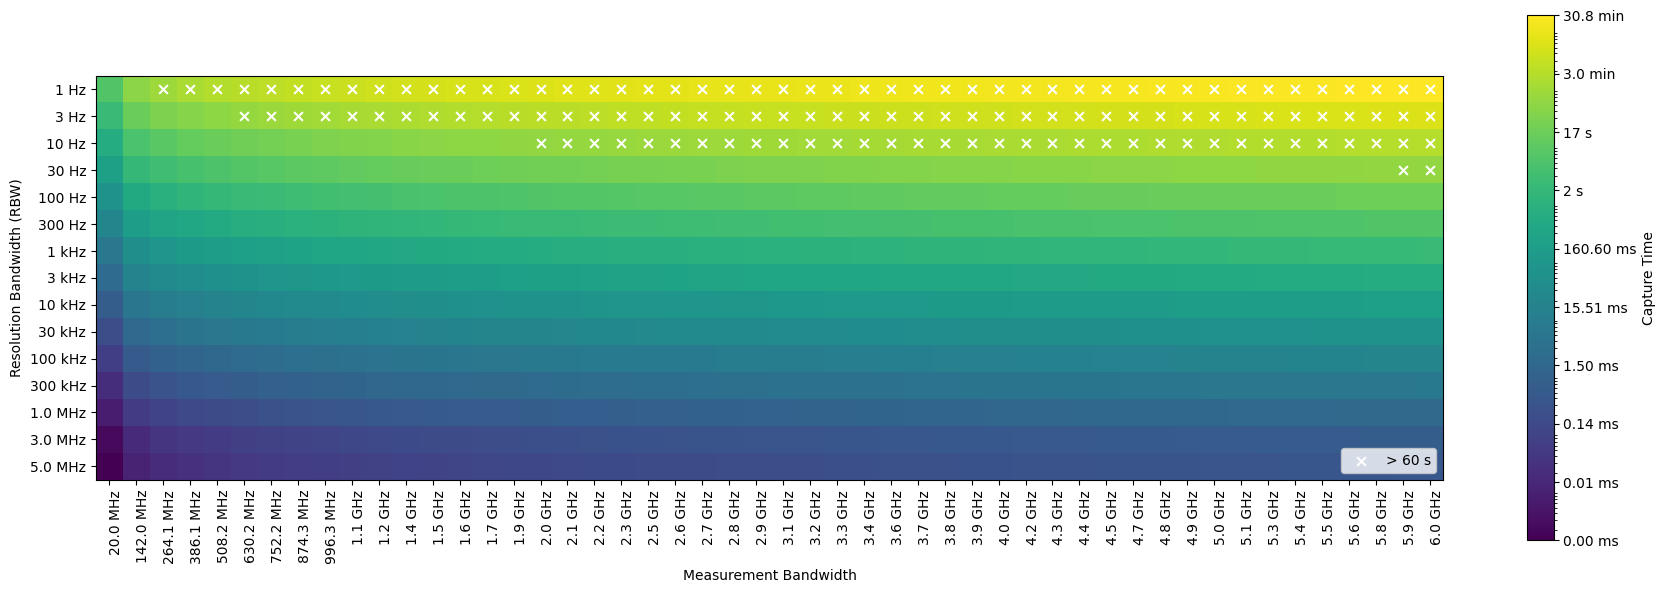

In [44]:
plot_capture_time_matrix(time_matrix, BW=BW_LIST, RBW=RBW_LIST, max_time_s=60)

### Estimated Data Size as a Function of Measurement Bandwidth and Resolution Bandwidth (RBW)

The estimated data size exhibits a strong dependence on the resolution bandwidth (RBW), following a pattern similar to that of capture time. As shown in the figure, decreasing the RBW leads to a sharp increase in required memory, since finer frequency resolution demands more samples to achieve narrower spectral bins. The regions marked with white “×” symbols correspond to configurations exceeding the 256 MiB memory threshold, highlighting the impracticality of very small RBWs at high sampling rates. In contrast, wider RBWs above 100 kHz maintain moderate memory requirements even for large measurement bandwidths up to 6 GHz. The color gradient demonstrates that memory consumption is primarily driven by RBW rather than total bandwidth, emphasizing that spectral resolution imposes the dominant constraint on data storage and buffer capacity in FFT-based acquisition systems.

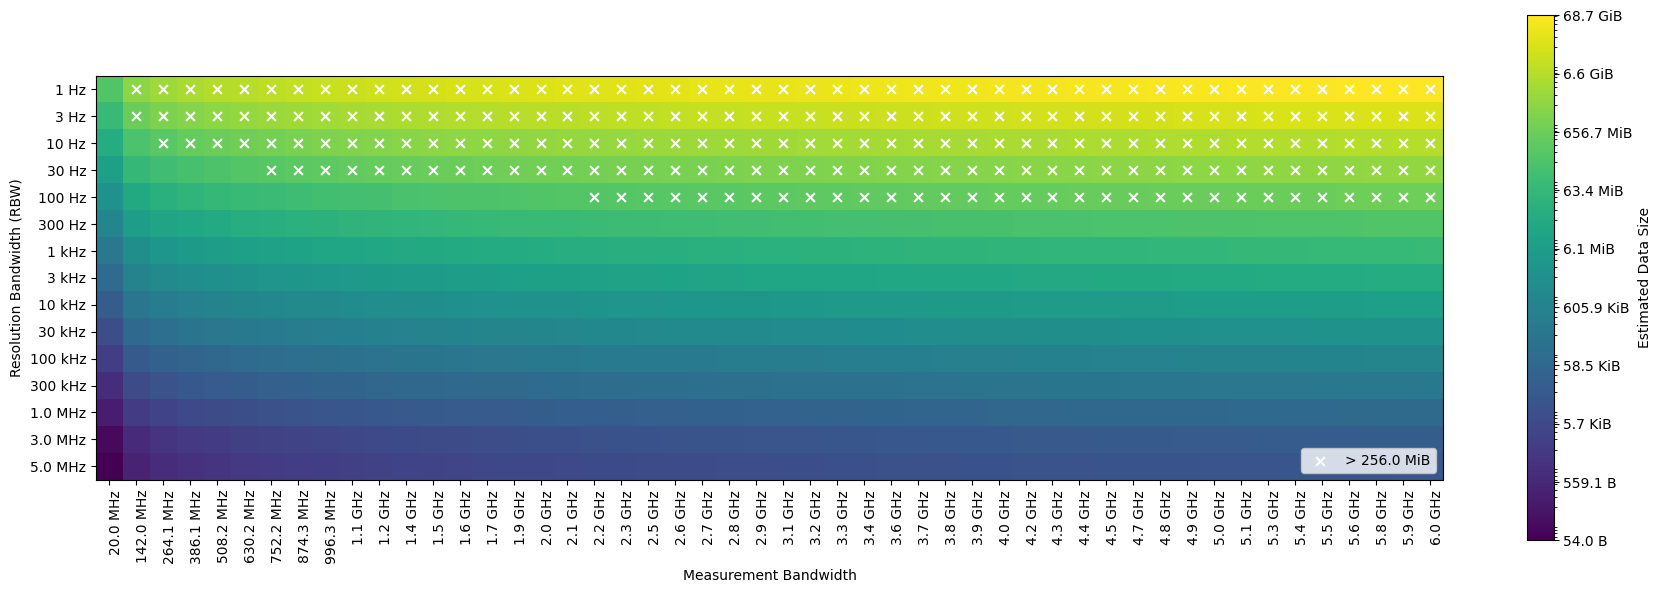

In [42]:
plot_memory_matrix(samples_matrix_kib, BW=BW_LIST, RBW=RBW_LIST, memory_limit_kib=256 * 1024)